### Importing utilities:

In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [10]:
import os
import csv
import random

from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt

%matplotlib inline

#### Setting up variables

In [8]:
PATH = "datasets/Kaggle_HPA_2018/"
PATH_to_data = "datasets/Kaggle_HPA_2018/train_10perc_v1_green/"
data_path = Path(PATH_to_data)
csv_path = Path(PATH)

In [17]:
CLASSES = ('WT', 'mfb1KO', 'mmr1KO', 'dnm1KO', 'fzo1KO', 'bud1KO', 'axl1KO')

name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

CLASSES = ()
CLASSES_list = range(0,28)

CLASSES = tuple(CLASSES_list)

NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = [2,224,224]

#### Calculating normalization statistics

Note that we are setting up train & val data, as well as test. Within test, we are here including a mutant cell type that the model never trains on. The idea is to use to the feature space developed during training to evaluate novel cell types by similarity to the landmarks that the model was trained on. 

In [14]:
# classes = Statistics.source_class(data_path)

# train_val = zip(classes['train'], classes['val'])
# test_ = zip(classes['test'])


# stats_name = "yeast_v11.1_per_class.dict"
# main_stats = Statistics.per_class(train_val, save_name = stats_name)
# test_stats = Statistics.per_class(test_)


# perc = 10
infile = "train_10perc_v2.csv"


# print(f"Generating random {perc}% subset of {infile}...")
    
with open(PATH + infile, 'r') as d:
    reader = csv.reader(d)
    train_data = np.vstack(list(reader))

# print(train_data)







Generating random 10% subset of train_10perc_v1.csv...


TypeError: 'builtin_function_or_method' object is not subscriptable

In [ ]:
for keys in main_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

In [ ]:
main_stats['02']

In [ ]:
for i in main_stats.keys():
    c0.append(main_stats[i][0][0]/main_stats[i][0][1])

In [ ]:
for keys in test_stats.keys():
    print(f"{keys}: \t \t \t {test_stats[keys]}")

## Defining datasets:

In [6]:
def tfms_for_test(stats, sz):
    test_norm = Normalize(stats, IntNorm=True)
    test_denorm = Denormalize(stats)
    val_crop = CropType.NO
    test_tfms = image_gen(test_norm, test_denorm,sz, crop_type=val_crop)
    return test_tfms

In [7]:
def get_data(path: str, sz, bs): # , num_workers=1
    create, lbl2index, lbl2index_test = ImageClassifierData.prepare_from_path(path, val_name='val', bs=bs, num_workers = 8,
                                                                             test_name='test', test_with_labels=True, balance=True)

    main_stats_X = {lbl2index[key][0]: val for key, val in main_stats.items()}
    augs = [RandomDihedral(),
#             Random_brightness(),
            RandomRotate(90),
            Gauss_noise(stats = main_stats_X, IntNorm=True)
           ]
    tfms = tfms_from_stats_IntNorm(main_stats_X, sz, aug_tfms=augs, crop_type=CropType.CENTER, pad=sz[1]//8)
    
    test_stats_X = {lbl2index_test[key][0]: val for key, val in test_stats.items()}
    test_tfms = tfms_for_test(test_stats_X,sz)
    tfms += (test_tfms, )
    
    return create(tfms), lbl2index, lbl2index_test

In [8]:
data, lbl2idx, lbl2idx_test = get_data(PATH,SIZE,BATCH_SIZE)

In [10]:
x , y = next(iter(data.trn_dl))

In [ ]:
print(data.aug_dl.dataset.transform.tfms)

### Inspect loaded data:

Displaying the same image with and without normalization.

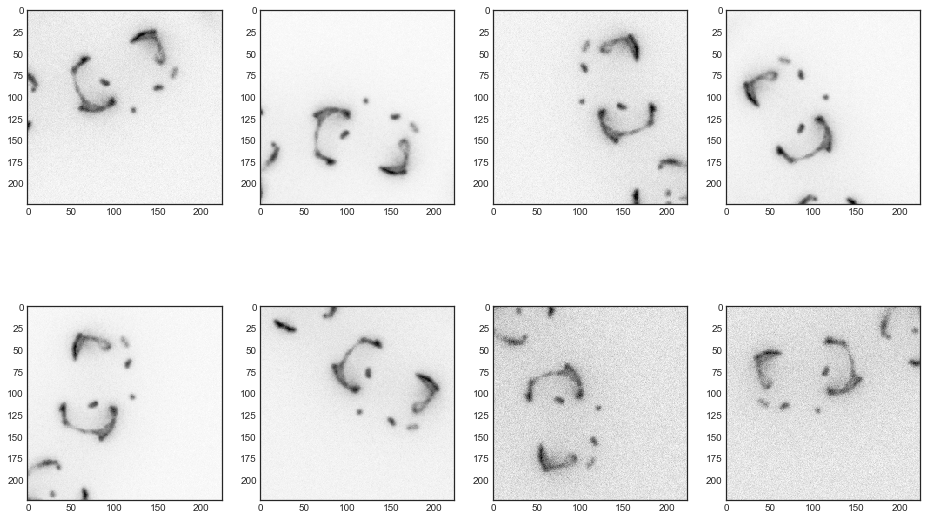

In [16]:
# print transformations
plt.style.use('seaborn-white')

c = 1
idx = 0
fig, ax = plt.subplots(2,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    x, y = next(iter(data.aug_dl))
    im = to_np(x)[idx]
#     ax.imshow(np.sum(im, axis = 0))
    ax.imshow(im[c])

In [ ]:
plt.style.use('seaborn-white')

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

    for b in range(0,len(dl)):
        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)

In [ ]:
xs, ys =  load_epoch()

In [ ]:
import seaborn as sns

In [ ]:
fig, axarr = plt.subplots(1, 2, figsize=(14, 8))

for i in [2,3]:
    
    xs_clss = xs[ys == i] 
    xs_sub = xs_clss[:100,...]
    xs_sub = xs_sub.reshape(-1,2,50176)
    
    ch0, ch1 = np.ravel(xs_sub[:,0]), np.ravel(xs_sub[:,1])
    print(ch1.shape)

    sns.kdeplot(ch0, ax = axarr[0], label = data.classes[i])
    sns.kdeplot(ch1, ax = axarr[1], label = data.classes[i])
    
axarr[0].set_xlim(-12,12);
axarr[1].set_xlim(-10,18);   
axarr[0].set_ylim(0,0.8);
axarr[1].set_ylim(0,1.8);
axarr[1].legend()

In [ ]:
fig, axarr = plt.subplots(1, 2, figsize=(14, 8))
colors = ['SteelBlue', 'Orange']
alphas = [1, 0.5]

for c,i in enumerate([2,3]):
    
    xs_clss = xs_bright[ys == i] 
    xs_sub = xs_clss[:20,...]
    xs_sub = xs_sub.reshape(-1,2,40000)
    col = colors[c]
    a = alphas[c]
    
    for im in range(20):
        ch0, ch1 = xs_sub[im,0], xs_sub[im,1]

        sns.kdeplot(ch0, ax = axarr[0], color = col, alpha = a)
        sns.kdeplot(ch1, ax = axarr[1], color = col, alpha = a)
        
axarr[0].set_xlim(-12,12);
axarr[1].set_xlim(-10,17);

In [ ]:
print(len(data.val_dl.dataset.y))
print(len(data.trn_dl.dataset.y))
print(len(data.test_dl.dataset.y))

# Training setup

In [ ]:
torch.cuda.is_available()

## ResNet_with_Batchnorm

Defining network architecture. 

In [17]:
arch = resnet18_c
# arch = resnet34_c

In [18]:
learn = ConvLearner.pretrained(arch, data, ps=0.25, opt_fn=optim.Adam, pretrained=False)

In [19]:
learn.unfreeze()

In [ ]:
learn.summary()

In [ ]:
learn.models.model

In [20]:
wd=1e-5 # weight-decay/L2 regularization 

In [25]:
learn.lr_find(1e-10)

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 35/38 [00:24<00:02,  1.43it/s, loss=2.48]

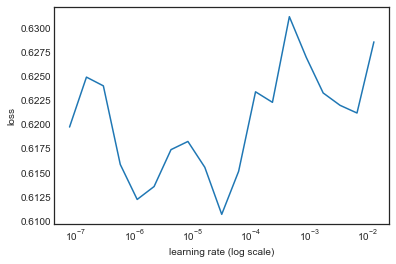

In [26]:
learn.sched.plot()

In [23]:
%time learn.fit(1e-2, 8, cycle_len=1, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 9                                                                                                                                                              
mean: [15.31579 12.65789 12.23684 15.07895 14.05263 13.52632 13.42105]
stdev: [4.28649 5.72288 5.7282  4.55598 3.81098 4.24721 4.97696]

[WT]: 40.0%
[mfb1KO]: 72.86%
[mmr1KO]: 65.71%
[axl1KO]: 32.86%
[bud1KO]: 14.29%
[dnm1KO]: 74.29%
[fzo1KO]: 68.57%
epoch      trn_loss   val_loss   accuracy   
    0      1.343732   1.14004    0.498413  
EPOCH 1 ---------------------------------------- STEP 10                                                                                                                                                             
mean: [15.15789 13.21053 14.42105 12.5     13.34211 13.57895 14.39474]
stdev: [4.88028 4.33564 4.78832 5.29026 5.47375 3.84319 4.77681]

[WT]: 20.48%
[mfb1KO]: 67.14%
[mmr1KO]: 71.43%
[axl1KO]: 22.86%
[bud1KO]: 74.29%
[dnm1KO]: 85.7

[array([0.95177]), 0.5476190476663529]

In [ ]:
f = plt.figure()
x = learn.sched.plot_loss()
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

In [ ]:
wd=1e-7 # weight-decay/L2 regularization 

In [ ]:
%time learn.fit(1e-3, 2, cycle_len=4, wds=wd, use_wd_sched=True)

In [ ]:
%time learn.fit(5e-6, 2, cycle_len=4, wds=wd, use_wd_sched=True)

In [ ]:
%time learn.fit(5e-4, 2, cycle_len=8, wds=wd, use_wd_sched=True)

In [ ]:
learn.sched.plot_lr()

#### Run some more cylces - error & accuracy should continuously improve

Note: cycle len = number of epochs per cycle

In [27]:
%time learn.fit(1e-3, 2, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 25                                                                                                                                                             
mean: [14.28947 14.18421 13.18421 14.31579 13.5     13.73684 13.31579]
stdev: [4.04519 4.418   4.47717 4.69101 3.97194 5.1077  5.38568]

[WT]: 35.71%
[mfb1KO]: 77.14%
[mmr1KO]: 78.57%
[axl1KO]: 28.57%
[bud1KO]: 55.71%
[dnm1KO]: 100.0%
[fzo1KO]: 92.86%
epoch      trn_loss   val_loss   accuracy   
    0      0.645347   0.889402   0.6       
EPOCH 1 ---------------------------------------- STEP 26                                                                                                                                                             
mean: [14.34211 13.81579 13.5     14.44737 13.92105 13.10526 13.60526]
stdev: [8.04682 5.35014 3.8234  4.96142 4.9862  5.91514 5.00284]

[WT]: 46.19%
[mfb1KO]: 77.14%
[mmr1KO]: 72.86%
[axl1KO]: 45.71%
[bud1KO]: 60.0%
[dnm1KO]: 98.5

Wall time: 8min 57s


[array([0.65942]), 0.6999999992431156]

In [29]:
%time learn.fit(1e-5, 2, cycle_len=4, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 49                                                                                                                                                             
mean: [15.60526 13.76316 13.28947 12.76316 13.31579 12.73684 15.31579]
stdev: [4.41612 5.64957 4.99952 4.39158 4.40756 4.6208  7.3703 ]

[WT]: 53.33%
[mfb1KO]: 87.14%
[mmr1KO]: 88.57%
[axl1KO]: 55.71%
[bud1KO]: 51.43%
[dnm1KO]: 97.14%
[fzo1KO]: 88.57%
epoch      trn_loss   val_loss   accuracy   
    0      0.577196   0.674547   0.698413  
EPOCH 1 ---------------------------------------- STEP 50                                                                                                                                                             
mean: [15.26316 13.5     13.05263 14.02632 13.      13.02632 14.63158]
stdev: [5.39339 4.48829 4.91479 5.25401 4.04579 4.74334 4.98641]

[WT]: 55.71%
[mfb1KO]: 91.43%
[mmr1KO]: 88.57%
[axl1KO]: 45.71%
[bud1KO]: 48.57%
[dnm1KO]: 95.

[array([0.66366]), 0.6936507926100777]

In [30]:
%time learn.fit(5e-7, 1, cycle_len=10, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 57                                                                                                                                                             
mean: [14.71053 14.21053 12.81579 12.31579 13.78947 15.07895 13.86842]
stdev: [4.18587 7.79392 3.29956 4.48451 3.98786 3.94289 5.24741]

[WT]: 57.62%
[mfb1KO]: 81.43%
[mmr1KO]: 85.71%
[axl1KO]: 42.86%
[bud1KO]: 51.43%
[dnm1KO]: 97.14%
[fzo1KO]: 91.43%
epoch      trn_loss   val_loss   accuracy   
    0      0.553781   0.675453   0.692063  
EPOCH 1 ---------------------------------------- STEP 58                                                                                                                                                             
mean: [12.36842 15.31579 13.05263 14.44737 13.21053 13.60526 14.47368]
stdev: [4.68155 4.02692 4.12277 5.62278 4.20625 3.94395 4.07002]

[WT]: 58.57%
[mfb1KO]: 81.43%
[mmr1KO]: 88.57%
[axl1KO]: 50.0%
[bud1KO]: 48.57%
[dnm1KO]: 98.5

[array([0.67067]), 0.6984126989803617]

In [ ]:
%time learn.fit(1e-4, 1, cycle_len=5, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-10, 1, cycle_len=3, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [ ]:
print(lbl2idx)

In [ ]:
learn.summary()

In [ ]:
learn.models.model

In [ ]:
learn.freeze_to(2)

In [ ]:
adjust = {0:22,
          1:14,
#           2:22,
          3:3,
          4:3,
         5:14,
         6:14
         }

# use_clr=(20,8, 0.95, 0.85),
%time learn.fit(1e-3, 1, cycle_len=8, wds=wd, use_wd_sched=True, adjust_class=adjust, best_save_name='YNet_v11.1_ResNet34_dihedral_ps025_IntNorm_rot90_rGauss_balanced_86_FT_mmr1')

## Analysis/Model evaluation

This is one of the major areas that needs improvement in our workflow. The tools we have so far (confusion matrix and manual inpsection of images) are essential but definitely not sufficient to ensure that our model learns something biologicaly relevant. Ideas are welcome!

### ...after training 

In [ ]:
learn.save('YNet_v11.2_ResNet18_dihedral_ps025_IntNorm_rot90_rGauss_balanced_92')

In [ ]:
## Load model:
learn.load('YNet_v11.1_ResNet18_dihedral_89')

In [ ]:
learn.freeze()

In [ ]:
%time learn.fit(1e-3, 1, cycle_len=1, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [ ]:
learn.lr_find()

In [31]:
log_preds, y = learn.TTA(n_aug=4) # run predictions with TTA

### Cross_validation evaluation

[[113   1   4  14  18   0   1]
 [  9  64   0   0   0   0   0]
 [  5   3  62   0   0   0   0]
 [ 39   0   3  34  12   0   0]
 [ 38   0   0  22  38   0   0]
 [  3   0   1   0   2  69   2]
 [  3   2   0   0   0   1  67]]


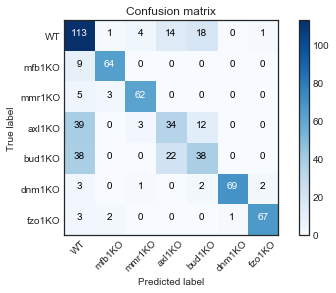

In [32]:
# Plot confusion matrix 
plt.style.use('seaborn-white')
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

## Test-set eval

In [ ]:
learn.models.model

In [33]:
# function to be called by register_forward_hook

def get_embeddings(layer_name):
    def register_hook(layer_name):
        def get_embedding(layer, inp, outp):
            tmp = inp[0]
            embedding.append(tmp)

        hook = layer.register_forward_hook(get_embedding) 
        
        for i in ['trn', 'val', 'test']:
            embedding = []
            preds, y = learn.predict_with_targs(i)
            
            # populating dict, consiting of [0]: preds, [1]: y, [2]: activations[layer]
            embeddings[i] = [preds, y, np.vstack(to_np(embedding))]
            
        hook.remove()
        
    embeddings = {}    
    layer = learn.models.model._modules.get(layer_name)
    register_hook(layer)
    
    return embeddings

In [34]:
embeddings = get_embeddings('14')

In [35]:
# unpacking embeddings

embs_trn = embeddings['trn'][2]
y_trn = embeddings['trn'][1]

embs_val = embeddings['val'][2]
y_val = embeddings['val'][1]

embs_test = embeddings['test'][2]
y_test = embeddings['test'][1]

print(embs_trn.shape)
print(embs_val.shape)
print(embs_test.shape)

print(y_trn.shape)
print(y_val.shape)
print(y_test.shape)


(2374, 512)
(630, 512)
(2721, 512)
(2374,)
(630,)
(2721,)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
# running PCA on embeddings
pca = []
n_components = 50
pca = PCA(n_components)

trn_pca_result = pca.fit_transform(embs_trn)
val_pca_result = pca.transform(embs_val)
test_pca_result = pca.transform(embs_test)

In [ ]:
#plotting compenent-wise cumulative explained variance (for PCA)

plt.plot(range(n_components), pca.explained_variance_ratio_)
plt.plot(range(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

In [ ]:
# running TSNE on embeddings

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embs_trn)

In [ ]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(7):
    PCA_cls = trn_pca_result[y_trn == i]
    TSNE_cls = tsne_results[y_trn == i]
    
    axarr[0].scatter(PCA_cls[:,compA], PCA_cls[:,compB], label = data.classes[i])
    axarr[1].scatter(TSNE_cls[:,compA], TSNE_cls[:,compB], label = data.classes[i])
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(7):
    trn_PCA_cls = trn_pca_result[y_trn == i]
    val_PCA_cls = val_pca_result[y_val == i]

    axarr[0].scatter(trn_PCA_cls[:,compA], trn_PCA_cls[:,compB], label = data.classes[i])
    axarr[1].scatter(val_PCA_cls[:,compA], val_PCA_cls[:,compB], label = data.classes[i])
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
print(lbl2idx_test)

In [ ]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(7):
    trn_PCA_cls = trn_pca_result[y_trn == i]

    axarr[0].scatter(trn_PCA_cls[:,compA], trn_PCA_cls[:,compB], label = data.classes[i])
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axarr[0].set_xlim(-15,45)
    axarr[0].set_ylim(-20,20)
    
for i in [0,1,3]:
    test_PCA_cls = test_pca_result[y_test == i]
    axarr[1].scatter(test_PCA_cls[:,compA], test_PCA_cls[:,compB], label = list(lbl2idx_test.keys())[i])
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axarr[1].set_xlim(-15,45)
    axarr[1].set_ylim(-20,20)


In [ ]:
list(lbl2idx_test.keys())[0]

In [ ]:
# Generate 3D TSNE space from PCA of embeddings

tsne3D = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300, learning_rate=50.0)
PCA2tSNE_results_3D = tsne3D.fit_transform(embs)

In [ ]:
tsne3D

In [ ]:
from mpl_toolkits import mplot3d

# magic command to make plots interactive.
# restart kernel if you want to switch to e.g. %matplotlib inline
%matplotlib notebook

In [ ]:
# 3D plotting - very slow interactivity atm...

fig = plt.figure()
ax = plt.axes(projection='3d')

compA = 0
compB = 1
compC = 2

for i in range(10):
    clss = PCA2tSNE_results_3D[y == i]
    cls_C = clss[0:500,:]
    ax.scatter3D(cls_C[:,compA], cls_C[:,compB], cls_C[:,compC])

In [36]:
import umap

In [37]:
UMAP_trn_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.3,
                      metric='correlation').fit(embs_trn)

UMAP_trn = UMAP_trn_embedding.embedding_
UMAP_val = UMAP_trn_embedding.transform(embs_val)
UMAP_test = UMAP_trn_embedding.transform(embs_test)

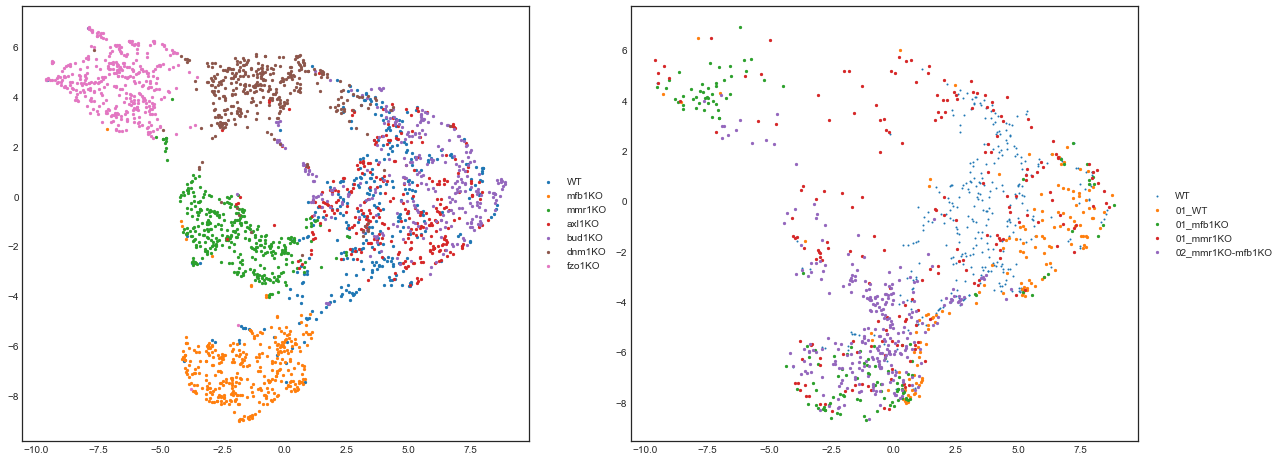

In [39]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(7):
    trn_UMAP_cls = UMAP_trn[y_trn == i]

    axarr[0].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if i == 0:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 1)

#     axarr[0].set_xlim(-22,15)
#     axarr[0].set_ylim(-15,12)
    
for i in [0,1,3,5]:
    test_UMAP_cls = UMAP_test[y_test == i]
    
    axarr[1].scatter(test_UMAP_cls[:,compA], test_UMAP_cls[:,compB], label = list(lbl2idx_test.keys())[i], s = 5)
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     axarr[1].set_xlim(-22,15)
#     axarr[1].set_ylim(-15,12)


In [ ]:
print(lbl2idx_test)

### Visualizing train and test datasets as exposed by dataloader

## @Yinan, please take the functionality of the next 2 cells and transfer it to the data_vis.py

In [ ]:
dl_ = data.trn_dl
batch_ = iter(dl_)


plt.style.use('seaborn-white')
fig = plt.figure()
ax = plt.subplot(111)

for b in range(0,len(dl_)):
    x_, y_ = next(batch_)

    x_np = to_np(x_)
    y_np = to_np(y_)
    
    im_means = np.mean(x_np, axis=(2,3))
    
    ax.plot(im_means[:,0], im_means[:,1], 'o', color = 'C0' , alpha=0.5)
        
plt.xlim(-0.4,0.4)
plt.ylim(-1, 4)

In [ ]:
dl_t = data.test_dl
batch_t = iter(dl_t)

plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.subplot(111)

for b in range(0,len(dl_t)):
    x_, y_ = next(batch_t)

    x_np = to_np(x_)
    y_np = to_np(y_)
    
    im_means = np.mean(x_np, axis=(2,3))
    
    ax.plot(im_means[:,0], im_means[:,1], 'o', color = 'C1' , alpha=0.5)
    
plt.xlim(-0.4,0.4)
plt.ylim(-1, 4)

### Inference

## @James, please transfer the functionality of the next 5 cells into the data_vis.py

In [ ]:
lbl2idx_test

In [40]:
test_log_preds, targs = learn.predict_with_targs('test')
testprobs = np.exp(test_log_preds)
preds = np.argmax(testprobs, axis=1)

In [41]:
test_log_preds.shape
preds.shape

(2721,)

In [42]:
# make predictions dictionary

h = 0
preds_dict = {}
for i, key in enumerate(lbl2idx_test.keys()):
    l = h
    h = h + list(data.test_dl.dataset.src_idx).count(i)
    preds_dict[key] = list(preds[l:h])
    print(f"{key} predictions ready ({h - l} elements)")

01_WT predictions ready (140 elements)
01_mfb1KO predictions ready (140 elements)
01_mmm1KO predictions ready (195 elements)
01_mmr1KO predictions ready (205 elements)
01_num1KO predictions ready (75 elements)
02_mmr1KO-mfb1KO predictions ready (284 elements)
03_DTT predictions ready (258 elements)
03_Eth predictions ready (260 elements)
03_H2O2 predictions ready (310 elements)
03_LatA-05uM predictions ready (309 elements)
03_axl1KO predictions ready (290 elements)
03_bud1KO predictions ready (255 elements)


In [43]:
preds_rel = {}
for key in preds_dict.keys():
    print(key)
    val = {cls: preds_dict[key].count(i)/len(preds_dict[key]) for i, cls in enumerate(data.classes)}
    preds_rel[key]= val

01_WT
01_mfb1KO
01_mmm1KO
01_mmr1KO
01_num1KO
02_mmr1KO-mfb1KO
03_DTT
03_Eth
03_H2O2
03_LatA-05uM
03_axl1KO
03_bud1KO


In [44]:
def plot_test_preds(targets, preds_rel):
    
    if not isinstance(targets, list):
        targets = [targets]
        
    x = math.ceil((int(len(targets)) /2)) # dynamic scaling of GridSpec
    sz = 4 * x # dynamic scaling of figuresize
    
    # plotting:
    plt.figure(figsize=(12,sz))
    gs1 = plt.GridSpec(x,2)
    gs1.update(wspace = 0.4)

    for i, targ in enumerate(targets):
        to_plot = [preds_rel[targ][key] for key in data.classes] # extracting data
        ax1 = plt.subplot(gs1[i])
        ax1.barh(data.classes, to_plot)
        ax1.set_title(targ)
        ax1.set_xlim(0,1)
    
    plt.show()

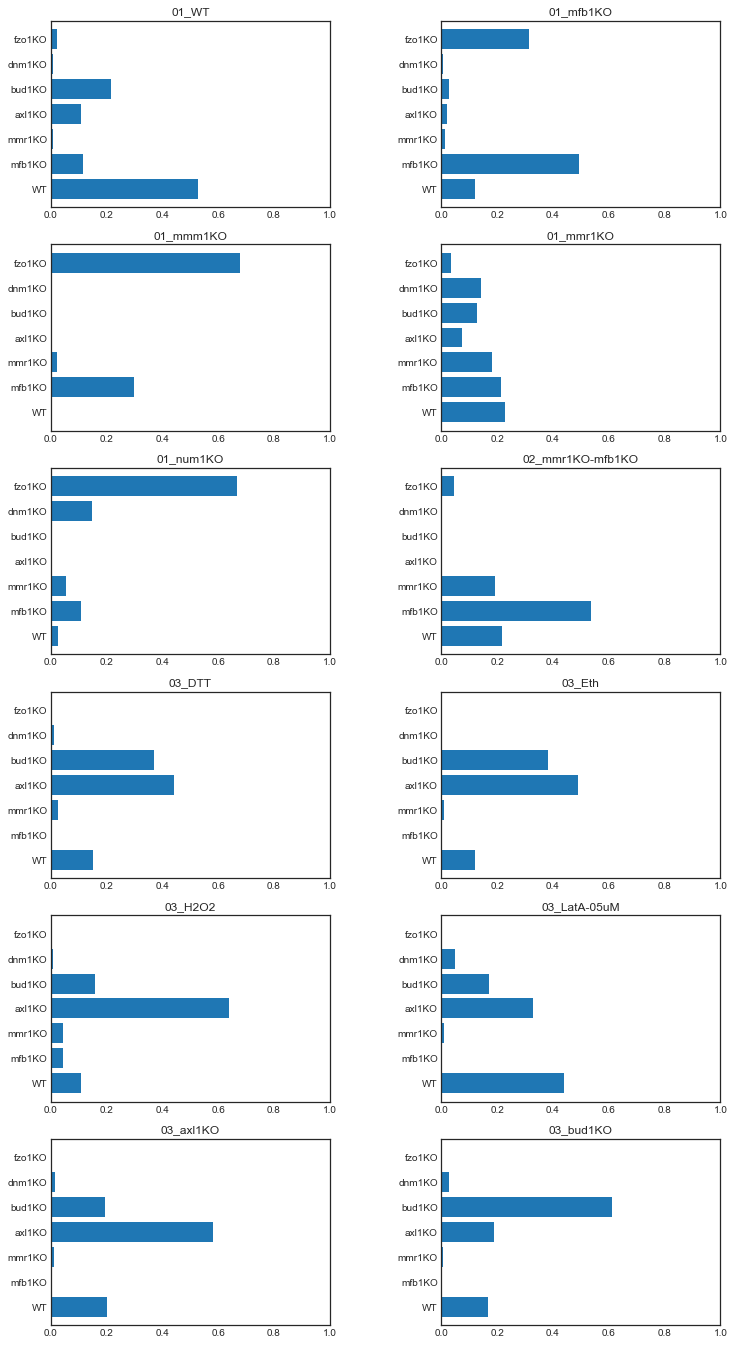

In [45]:
test_classes = list(lbl2idx_test.keys())

plot_test_preds(test_classes, preds_rel)
# plot_test_preds(['01_WT', '03_WT', '03_fzo1KO', '01_mfb1KO'], preds_rel)
# plot_test_preds(['01_WT', '01_mfb1KO', '01_mmr1KO'], preds_rel)

### Analyse images 

#### Show random correct/incorrectly classified images:

In [ ]:
log_preds_mean = np.mean(log_preds, axis=0) # averages predictions on original + 4 TTA images
preds = np.argmax(log_preds_mean, axis=1) # converts into 0 or 1

In [ ]:
# probs = np.exp(log_preds_mean[:,0]) # prediction(WT)
probs = np.exp(log_preds_mean) # predictions

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plots(ims, channel, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=11)
        if channel is not None: plt.imshow(ims[i,channel,:,:]) 
        else: plt.imshow(np.sum(ims, axis=1)[i,:,:])

In [ ]:
def plot_val_with_title_from_ds_no_denorm(idxs, title, channel=None):
    
    imgs = np.stack(data.val_ds[x][0] for x in idxs) # get images by idx
    corr_lbl = np.stack(data.val_ds[x][1] for x in idxs) # get correct label from data.val_ds by idx
    pred_lbl = np.stack(preds[x] for x in idxs) # get predicted label from preds by idx
    p_max = [np.amax(probs[x,:]) for x in idxs] # get highest probability from probs by idx
    
    title_fin = [f"true = {corr_lbl[x]}\n predicted: {pred_lbl[x]}\n  p = {p_max[x]}" for x, _ in enumerate(corr_lbl)]
    print(title)
    
    return plots(imgs, channel, rows=1, titles=title_fin, figsize=(16,8))

In [ ]:
lbl2idx_

### Plot images according to predictions

In [ ]:
# load from ds - not denormalized! 
plot_val_with_title_from_ds_no_denorm(rand_by_correct(True), "Correctly classified")
#optionally pass channel arg. to select single channel

In [ ]:
plot_val_with_title_from_ds_no_denorm(rand_by_correct(False), "Incorrectly classified")

#### Show most correct/incorrectly classified images per class:

In [ ]:
def most_by_mask(mask, y, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[:,y][idxs])[0:5]]

def most_by_correct(y, is_correct): 
    mult = -1 if is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), y, mult)

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, True), "Most correctly classified WT")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, False), "Most incorrectly classified WT") # logic?

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, True), "Most correctly classified mfb1KO") 

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, False), "Most incorrectly classified mfb1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(2, True), "Most correctly classified mfb1KO-mmr1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(3, True), "Most correctly classified CK666")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(4, True), "Most correctly classified LatA")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(5, True), "Most correctly classified dnnm1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(6, True), "Most correctly classified fzo1KO")

#### Show (most) uncertain images

In [ ]:
most_uncertain = t = np.argsort(np.amax(probs, axis = 1))[1:5] # get best "guess" per image and list the least confident ones
plot_val_with_title_from_ds_no_denorm(most_uncertain, "Most uncertain predictions")

In [ ]:
lbl2idx_